In [1]:
import pandas as pd
import numpy as np
import sys
import os.path
import pickle
import time
import re
import math
import sklearn_pandas
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline


# Load
Read the file resulting from the scraping:

In [2]:
# Location of the dataframe pickle file containing all the boat data:
boats_df_path = './data/boats_df.pkl'
if os.path.isfile(boats_df_path):
    df = pd.read_pickle(boats_df_path)
    print(len(df),' boats read from file into boats_df.')

3001  boats read from file into boats_df.


In [3]:
df.head()

,price,make,model,year,cls,length_ft,LOA_ft,displacement_lb,fuel_type,power_hp,eng_make,eng_model,eng_year,eng_hrs,location
5637501,Request Price,Bali,4.5,2020,Catamaran,45,45 ft,32800,Diesel,50,None,None,2016,50,"All Locations, California"
7213466,89500,Beneteau,OC 400,1996,Sloop,40,40 ft,19200,Diesel,None,Perkins,M-50,None,None,"Kenosha , Wisconsin"
7216014,125900,Hunter,466,2002,Cruiser (Sail),46,46 ft 1 in,26180,Diesel,76,Yanmar,None,2002,938,"Stamford, Connecticut"
7191853,265000,Jeanneau,Sun Odyssey 419,2018,Cruiser (Sail),42,41 ft 10 in,None,Diesel,45,Yanmar,None,None,300,"Portsmouth, Rhode Island"
7152732,388900,Fountaine Pajot,Orana 44,2012,Multi-Hull,44,44 ft,None,Diesel,None,Volvo Penta,D2-40,2012,5270,"St Thomas, United States"


I'm going to rename the feature 'year' to 'year_str'

In [4]:
df.rename(columns={'year':'year_str'},inplace=True)
df.rename(columns={'price':'price_str'},inplace=True)

# Clean
Clean steps to prepare the data for modeling:

In [5]:
# There are no null values in the year or length so they can simply be converted to int:
df['year'] = df['year_str'].astype(int)
df['length_ft'] = df['length_ft'].astype(int)
df.describe()

,length_ft,year
count,3001.000000,3001.000000
mean,44.270910,2001.953682
std,2.981652,13.748413
min,40.000000,1860.000000
25%,42.000000,1996.000000
50%,44.000000,2005.000000
75%,46.000000,2011.000000
max,50.000000,2020.000000


# Price
The MVP coerced the price strings to floats which returned `None`'s for all values in
currency other than US$.  I'll fix that now.  I need ASCII codes for Euro and pound:

$ \def\euro{\unicode{x20AC}}$
$ \def\yen{\unicode{x00A5}}$
$ \def\pound{\unicode{x00A3}}$
$ \def\dollar{\unicode{x024}}$
$euro = \euro$ is ASCII 8364  
$pound = \pound$ is ASCII 163

In [6]:
print('euro = ',chr(8364))
print('pound = ',chr(163))

euro =  €
pound =  £


This function is designed to be used with df.apply() to convert the 
column 'price_str' to Oct 8, 2019 US$'s.

In [7]:
def Currency_Converter(row):
    """
    Coverts dataframe series values named 'price_str' to US$
    using converstion rates on 10/8/2019
    """

    first_price_char = row.price_str.strip()[0]
    if row.price_str == 'Request Price':  # New Boat
        return None
    price = float(re.search('\d+', row.price_str).group(0))
    if re.match(r'\d',first_price_char):  # US$
        return price
    if first_price_char == chr(8364):  # Euro
        return price * 1.10
    if first_price_char == chr(163):  # British Pound
        return price * 1.22
    if first_price_char == 'A':   # Austrialian $
        return price * 0.67
    if row.price_str[:2] == 'CA':
        return price * 0.75
    if row.price_str[:2] == 'NZ':
        return price * 0.63
    if row.price_str[:3] == 'Dkr':
        return price * 0.15
    return None

# Prices had 'US$' stripped but for other denominations there are still symbol characters:
# Convert all price strings to US$ using Currency_Converter above
df['price_USD'] = df.apply(Currency_Converter,axis=1).copy()
df.price_USD.describe()

count    2.912000e+03
mean     1.821184e+05
std      1.378925e+05
min      9.760000e+03
25%      9.570000e+04
50%      1.430000e+05
75%      2.220500e+05
max      3.000000e+06
Name: price_USD, dtype: float64

# Data Cleaning

In [8]:
# I'm going to drop the 2 outlier price values
df.drop(df.price_USD.idxmax(), inplace=True)
df.drop(df.price_USD.idxmax(), inplace=True)
# There is 1 boat of type class identified as 'Commercial Boat (Sail)'
# I'm going to change it to 'Cruiser/Racer'
df.loc[df[df.cls == 'Commercial Boat (Sail)'].index,['cls']] = 'Cruiser/Racer'
# I'll make the capitalization of the makes contistent:
df['make'] = df['make'].str.title()

Lets see if we can bring in make:

In [9]:
makes = df['make'].value_counts()
len(makes)

404

If I exclude makes have have fewer than 5 and call the others "Other" I'll have:

In [10]:
len(makes[df['make'].value_counts() > 1])

162

In [11]:
sum(makes[df['make'].value_counts() < 3])

354

Creating a feature in df called mfg:

In [12]:
makes = df['make'].value_counts()
makes = makes[df['make'].value_counts() > 2]
df['mfg'] = df.make.apply(lambda make: make if make in makes else 'Other')
print('Number of boats categrized as "Other": ',len(df[df.mfg == 'Other']))

Number of boats categrized as "Other":  354


In [13]:
df.cls.value_counts()

Cruiser (Sail)                2255
Cruiser/Racer                  229
Sloop                          147
Multi-Hull                      98
Catamaran                       73
Center Cockpit                  44
Racer                           36
Ketch                           32
Cutter                          29
Antique and Classic (Sail)      18
Deck Saloon                     17
Pilothouse (Sail)                8
Daysailer                        6
Motorsailer (Sail)               4
Schooner                         3
Name: cls, dtype: int64

In [14]:
#df.info()

Grab the parts of df that will be modeled and eliminate rows that have None's.

In [15]:
data = df.loc[:,['year','price_USD','length_ft', 'mfg', 'cls']].copy()
data.dropna(inplace=True)
X = data[['year', 'length_ft', 'mfg', 'cls']]
y = data['price_USD']

In [16]:
# Divide the data into test and train sets:
X_train, X_test, lny_train, lny_test = train_test_split(X, np.log(y), test_size=.2, random_state=42)

In [17]:
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import make_pipeline
#posTransform = make_pipeline(FunctionTransformer(np.log), StandardScaler())
    # (['Lot Area', 'Gr Liv Area'], posTransform),
mapper = DataFrameMapper([
        (['year', 'length_ft'], StandardScaler()),
        (['mfg', 'cls'], OneHotEncoder())
        ])

pipe = make_pipeline(mapper, LassoCV(cv=5, alphas=np.logspace(-2,-5,100)))
#pipe = make_pipeline(mapper, LinearRegression())

In [18]:
pipe.fit(X_train,lny_train)

Pipeline(memory=None,
         steps=[('dataframemapper',
                 DataFrameMapper(default=False, df_out=False,
                                 features=[(['year', 'length_ft'],
                                            StandardScaler(copy=True,
                                                           with_mean=True,
                                                           with_std=True)),
                                           (['mfg', 'cls'],
                                            OneHotEncoder(categorical_features=None,
                                                          categories=None,
                                                          drop=None,
                                                          dtype=<class 'numpy.float64'>,
                                                          handle_unknown='error',
                                                          n_values=None,
                                                          s

In [19]:
lcv = pipe.steps[1][1]

In [20]:
(np.log(lcv.alphas_[0]) - np.log(lcv.alpha_))/(np.log(lcv.alphas_[0]) - np.log(lcv.alphas_[-1]))

0.5555555555555556

In [21]:
print('Coeficients = 0: ', len(lcv.coef_[lcv.coef_==0]))
print('Total Coefficiencts: ', len(lcv.coef_))

Coeficients = 0:  26
Total Coefficiencts:  124


In [22]:
lcv.alpha_

0.00021544346900318823

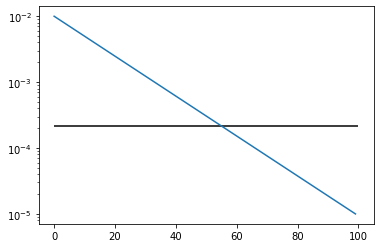

In [24]:
plt.plot(lcv.alphas_)
plt.hlines(lcv.alpha_,0,100)
#plt.plot(np.logspace(-1,-4,100))
plt.semilogy();

In [26]:
y_pred_test = np.exp(pipe.predict(X_test))
y_pred_train = np.exp(pipe.predict(X_train))
resid_train = lny_train - pipe.predict(X_train)
resid_test = lny_test - pipe.predict(X_test)
r2_train = pipe.score(X_train,lny_train)
r2_test = pipe.score(X_test,lny_test)
RMSE_test = math.sqrt(mean_squared_error(lny_test,pipe.predict(X_test)))
RMSE_train = math.sqrt(mean_squared_error(lny_train,pipe.predict(X_train)))

In [27]:
print(round(RMSE_test,3),round(RMSE_train,3))

0.347 0.384


R2 Train:  0.6345845923825556
R2 Test:  0.6741590215643697


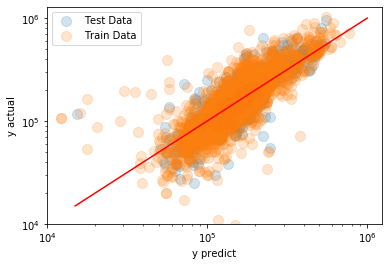

In [28]:
#Plot the Actual by Predicted
fig,ax = plt.subplots(1,1);
ax.scatter(y_pred_test,np.exp(lny_test),label='Test Data', s=100, alpha=0.2)
ax.scatter(y_pred_train,np.exp(lny_train),label='Train Data', s=100, alpha=0.2)
ax.plot([1.5E4,1E6],[1.5E4,1E6],color='r')
ax.semilogx()
ax.semilogy()
ax.set_xlim(left=10000)
ax.set_ylim(bottom=10000)
ax.set_ylabel('y actual')
ax.set_xlabel('y predict')
ax.legend();
print('R2 Train: ', r2_train)
print('R2 Test: ', r2_test)

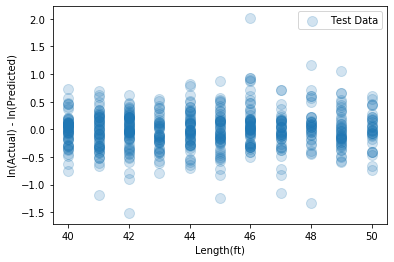

In [29]:
#Plot the Actual by Predicted
fig,ax = plt.subplots(1,1);
ax.scatter(X_test.length_ft,resid_test,label='Test Data', s=100, alpha=0.2)
#ax.scatter(X_train.length_ft,resid_train,label='Train Data', s=100, alpha=0.2)
ax.set_ylabel('ln(Actual) - ln(Predicted)')
ax.set_xlabel('Length(ft)')
ax.legend();

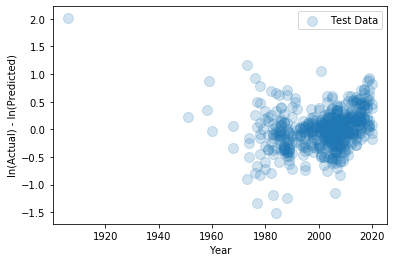

In [30]:
#Plot the Actual by Predicted
fig,ax = plt.subplots(1,1);
ax.scatter(X_test.year,resid_test,label='Test Data', s=100, alpha=0.2)
#ax.scatter(X_train.year,resid_train,label='Train Data', s=100, alpha=0.2)
#ax.set_xlim(left=1960)
ax.set_ylabel('ln(Actual) - ln(Predicted)')
ax.set_xlabel('Year')
ax.legend();